In [548]:
import numpy as np
import pandas as pd
from fast_ml.model_development import train_valid_test_split
from transformers import Trainer, TrainingArguments, AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch import nn
from torch.nn.functional import softmax
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import datasets


In [549]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")


tensor([1.], device='mps:0')


In [552]:
df = pd.read_csv('news_data/labeled.csv')

In [553]:
df.columns

Index(['Unnamed: 0', 'Published Date', 'Title', 'AllSides Content', 'URL',
       'News Channel', 'News Channel URL', 'Bias', 'Tags', 'topic',
       'News Article Content', 'Distil_Summary', 'Falcons_Summary',
       'Bart_Summary', 'Processed text', 'Sentiment_Content_nltk',
       'Processed Distil', 'Sentiment_Distil_nltk', 'Processed Falcons',
       'Sentiment_Falcons_nltk', 'Processed Bart', 'Sentiment_Bart_nltk',
       'Sentiment_Content_cardiffnlp', 'Sentiment_Distil_cardiffnlp',
       'Sentiment_Falcons_cardiffnlp', 'Sentiment_Bart_cardiffnlp'],
      dtype='object')

In [554]:
df

,Unnamed: 0,Published Date,Title,AllSides Content,URL,News Channel,News Channel URL,Bias,Tags,topic,...,Processed Distil,Sentiment_Distil_nltk,Processed Falcons,Sentiment_Falcons_nltk,Processed Bart,Sentiment_Bart_nltk,Sentiment_Content_cardiffnlp,Sentiment_Distil_cardiffnlp,Sentiment_Falcons_cardiffnlp,Sentiment_Bart_cardiffnlp
0,0,Feb 21 2024,Reproductive policy fights renew the focus on IVF,An Alabama Supreme Court decision legally reco...,https://www.allsides.com/news/2024-02-21-1315/...,Roll Call,https://rollcall.com/2024/02/20/reproductive-p...,center,"['Supreme Court', 'Healthcare', 'Pregnancy', '...",abortion,...,alabama supreme court ruled friday frozen embr...,0.0772,court friday ruled frozen embryo considered un...,0.0000,alabama supreme court ruled friday frozen embr...,0.4215,0.000000,-0.686311,0.000000,-0.585119
1,1,Mar 24 2024,'Some serious stigma': Arizona lawmaker explai...,Democratic Sen. Eva Burch got call from VP Har...,https://www.allsides.com/news/2024-03-24-1430/...,12News,https://12news.com/article/news/politics/sunda...,center,['Abortion'],abortion,...,NaN,0.0000,NaN,0.0000,NaN,0.0000,0.000000,0.000000,0.000000,0.000000
2,2,Apr 08 2024,Trump says he’s in favor of letting states dec...,NEW YORK — Former President Donald Trump said ...,https://www.allsides.com/news/2024-04-08-1130/...,San Jose Mercury News,https://mercurynews.com/2024/04/08/trump-says-...,left,['Abortion'],abortion,...,NaN,0.0000,NaN,0.0000,NaN,0.0000,0.000000,0.000000,0.000000,0.000000
3,3,Mar 01 2024,CVS and Walgreens Will Begin Selling Abortion ...,The two largest pharmacy chains in the United ...,https://www.allsides.com/news/2024-03-01-1330/...,New York Times (News),https://www.nytimes.com/2024/03/01/health/abor...,left,"['Abortion', 'Abortion Pills', 'Public Health'...",abortion,...,cv walgreens start dispensing abortion pill mi...,0.6249,official cv walgreens said interview friday re...,0.0000,cv walgreens start dispensing abortion pill mi...,0.5106,0.616519,0.520035,0.000000,0.560467
4,4,Feb 02 2024,Wyoming Supreme Court Says Pro-Lifers Can't In...,The Wyoming Supreme Court on Friday denied a p...,https://www.allsides.com/news/2024-02-02-1225/...,Cowboy State Daily,https://cowboystatedaily.com/2024/02/02/wyomin...,right,"['Abortion', 'Supreme Court']",abortion,...,NaN,0.0000,NaN,0.0000,NaN,0.0000,-0.525758,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1805,9344,Mar 22 2024,The mayor is an immigrant. His conservative ci...,The mayor is an immigrant. His conservative ci...,https://www.allsides.com/news/2024-03-22-0330/...,Washington Post,https://washingtonpost.com/nation/2024/03/22/c...,left,['Politics'],immigration,...,NaN,0.0000,NaN,0.0000,NaN,0.0000,0.000000,0.000000,0.000000,0.000000
1806,9366,Mar 19 2024,Prof. Douglas Smith helps combat ongoing Massa...,Massachusetts has reportedly reached its . How...,https://www.allsides.com/news/2024-03-19-0333/...,The Justice,https://thejustice.org/article/2024/03/prof-do...,left,['General News'],immigration,...,"massachusetts right-to-shelter state , meaning...",0.1280,massachusetts reportedly reached maximum capac...,0.2263,massachusetts reportedly reached maximum capac...,0.1027,0.000000,0.000000,0.000000,0.000000
1807,9414,Apr 08 2024,Oklahoma may adopt Texas-style illegal immigra...,OKLAHOMA CITY — State lawmakers may soon consi...,https://www.allsides.com/news/2024-04-08-1032/...,Tulsa World,https://tulsaworld.com/news/state-regional/gov...,center,"['Oklahoma', 'Tulsa', 'Immigration']",immigration,...,NaN,0.0000,NaN,0.0000,NaN,0.0000,0.000000,0.000000,0.000000,0.000000
1808,9541,Mar 13 2024,"DeSantis Blasts Libs Of TikTok For ""Lying abou...",Florida Governor Ron DeSantis (R) slammed righ...,https://www.allsides.com/news/2024-03-13-1355/...,JoeMyGod,https://joemygod.com/2024/03/desantis-blasts-l...,left,['General News'],immigration,...,florida governor ron desantis ( r ) slammed ri...,0.4404,florida governor ron des

In [555]:
df.shape[0]

1810

In [556]:
data = df[["Title","News Channel","Bias","topic",\
             "News Article Content","Distil_Summary","Falcons_Summary","Bart_Summary","Sentiment_Content_nltk","Sentiment_Distil_nltk",\
                "Sentiment_Falcons_nltk","Sentiment_Bart_nltk","Sentiment_Content_cardiffnlp", "Sentiment_Distil_cardiffnlp", \
               "Sentiment_Falcons_cardiffnlp", "Sentiment_Bart_cardiffnlp"]]
data.head(10)

,Title,News Channel,Bias,topic,News Article Content,Distil_Summary,Falcons_Summary,Bart_Summary,Sentiment_Content_nltk,Sentiment_Distil_nltk,Sentiment_Falcons_nltk,Sentiment_Bart_nltk,Sentiment_Content_cardiffnlp,Sentiment_Distil_cardiffnlp,Sentiment_Falcons_cardiffnlp,Sentiment_Bart_cardiffnlp
0,Reproductive policy fights renew the focus on IVF,Roll Call,center,abortion,An Alabama Supreme Court decision legally reco...,Alabama Supreme Court ruled Friday that frozen...,The court on Friday ruled frozen embryos are c...,The Alabama Supreme Court ruled Friday that f...,0.9900,0.0772,0.0000,0.4215,0.000000,-0.686311,0.000000,-0.585119
1,'Some serious stigma': Arizona lawmaker explai...,12News,center,abortion,Democratic Sen. Eva Burch got call from VP Har...,NaN,NaN,NaN,0.9524,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000
2,Trump says he’s in favor of letting states dec...,San Jose Mercury News,left,abortion,By Jill Colvin | Associated Press\n\nNEW YORK ...,NaN,NaN,NaN,0.7886,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000
3,CVS and Walgreens Will Begin Selling Abortion ...,New York Times (News),left,abortion,The two largest pharmacy chains in the United ...,CVS and Walgreens will start dispensing the ab...,Officials at CVS and Walgreens said in intervi...,CVS and Walgreens will start dispensing the a...,0.9612,0.6249,0.0000,0.5106,0.616519,0.520035,0.000000,0.560467
4,Wyoming Supreme Court Says Pro-Lifers Can't In...,Cowboy State Daily,right,abortion,The Wyoming Supreme Court on Friday denied a p...,NaN,NaN,NaN,0.9217,0.0000,0.0000,0.0000,-0.525758,0.000000,0.000000,0.000000
5,"New gun, abortion and labor laws take effect i...",Detroit Free Press,left,abortion,New Michigan laws approved by Democrats take e...,New Michigan laws approved by Democrats take e...,"Democrats repealed Michigan's ""right-to-work"" ...","Democrats repealed Michigan's ""right-to-work""...",-0.9689,0.6395,0.3612,0.0000,0.000000,0.000000,0.000000,0.000000
6,Latest 2024 election news: Harris returning to...,Washington Post,left,abortion,Election 2024\n\nGet the latest news on the 20...,President Biden and Donald Trump both secured ...,Election 2024 Get the latest news on the elect...,President Biden and Donald Trump both secured...,0.7964,0.7964,0.4019,0.7964,0.000000,0.000000,0.000000,0.574264
7,New York pro-lifers march with ‘joy on steroids’,Catholic News Agency,right,abortion,The New York Police Department arrested at lea...,The International Gift of Life Walk was held i...,The New York Police Department arrested at lea...,Hundreds of pro-lifers joined the Internation...,0.8101,0.7351,0.6908,0.6908,-0.589605,0.462740,0.669605,0.702206
8,How A Leftist Network Of Websites Floods Red S...,The Daily Wire,right,abortion,"Facilitated by Left-wing activist groups, a ne...",NaN,NaN,NaN,0.9988,0.0000,0.0000,0.0000,-0.599504,0.000000,0.000000,0.000000
9,Trump eyes abortion declaration as polls show ...,MSNBC,left,abortion,"In recent weeks, Donald Trump has made clear t...",Donald Trump has said he'll make a statement o...,"In recent weeks, Donald Trump has made clear t...",Donald Trump has made clear that he's prepare...,0.9883,-0.3818,0.8316,0.5423,0.000000,0.000000,0.000000,0.000000


In [557]:
data = data[data["Distil_Summary"].notna() & data["Falcons_Summary"].notna() & data["Bart_Summary"].notna()]


In [558]:
data

,Title,News Channel,Bias,topic,News Article Content,Distil_Summary,Falcons_Summary,Bart_Summary,Sentiment_Content_nltk,Sentiment_Distil_nltk,Sentiment_Falcons_nltk,Sentiment_Bart_nltk,Sentiment_Content_cardiffnlp,Sentiment_Distil_cardiffnlp,Sentiment_Falcons_cardiffnlp,Sentiment_Bart_cardiffnlp
0,Reproductive policy fights renew the focus on IVF,Roll Call,center,abortion,An Alabama Supreme Court decision legally reco...,Alabama Supreme Court ruled Friday that frozen...,The court on Friday ruled frozen embryos are c...,The Alabama Supreme Court ruled Friday that f...,0.9900,0.0772,0.0000,0.4215,0.000000,-0.686311,0.000000,-0.585119
3,CVS and Walgreens Will Begin Selling Abortion ...,New York Times (News),left,abortion,The two largest pharmacy chains in the United ...,CVS and Walgreens will start dispensing the ab...,Officials at CVS and Walgreens said in intervi...,CVS and Walgreens will start dispensing the a...,0.9612,0.6249,0.0000,0.5106,0.616519,0.520035,0.000000,0.560467
5,"New gun, abortion and labor laws take effect i...",Detroit Free Press,left,abortion,New Michigan laws approved by Democrats take e...,New Michigan laws approved by Democrats take e...,"Democrats repealed Michigan's ""right-to-work"" ...","Democrats repealed Michigan's ""right-to-work""...",-0.9689,0.6395,0.3612,0.0000,0.000000,0.000000,0.000000,0.000000
6,Latest 2024 election news: Harris returning to...,Washington Post,left,abortion,Election 2024\n\nGet the latest news on the 20...,President Biden and Donald Trump both secured ...,Election 2024 Get the latest news on the elect...,President Biden and Donald Trump both secured...,0.7964,0.7964,0.4019,0.7964,0.000000,0.000000,0.000000,0.574264
7,New York pro-lifers march with ‘joy on steroids’,Catholic News Agency,right,abortion,The New York Police Department arrested at lea...,The International Gift of Life Walk was held i...,The New York Police Department arrested at lea...,Hundreds of pro-lifers joined the Internation...,0.8101,0.7351,0.6908,0.6908,-0.589605,0.462740,0.669605,0.702206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801,Maria Hunter,Los Angeles Times,left,immigration,"SVP, Relationship Manager Team Lead Enterprise...","Maria Hunter is SVP, Relationship Manager Team...","SVP, Relationship Manager Team Lead Enterprise...","Maria Hunter, a Nicaraguan native, immigrated...",0.9834,0.9371,0.7650,0.5106,0.000000,0.744264,0.000000,0.889746
1803,Ecuador President visits NJCU; Archdiocese and...,nj.com,center,immigration,NJCU hosts Ecuadorian president\n\nNew Jersey ...,NJCU hosts Ecuadorian president Daniel Noboa. ...,NJCU hosts Ecuadorian president New Jersey Cit...,"Daniel Noboa, the newly-elected president of ...",0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000
1804,El Paso County Commission candidate has histor...,Colorado Springs Gazette,center,immigration,Close Get email notifications on {{subject}} d...,Close Get email notifications on this story ev...,Close Get email notifications on subject daily...,Get ready for the holidays with your favorite...,0.1007,0.0000,0.0000,0.9300,0.000000,0.000000,0.000000,0.664028
1806,Prof. Douglas Smith helps combat ongoing Massa...,The Justice,left,immigration,Massachusetts has reportedly reached its maxim...,Massachusetts is the only Right-to-Shelter sta...,Massachusetts has reportedly reached its maxim...,Massachusetts has reportedly reached its maxi...,0.9884,0.1280,0.2263,0.1027,0.000000,0.000000,0.000000,0.000000


In [559]:
data.shape[0]

1324

In [560]:
data.topic.value_counts()

topic
healthcare        288
sustainability    228
public-health     227
environment       201
abortion          196
immigration       184
Name: count, dtype: int64

In [561]:
topic_mapping = {
    'public-health': 'Public Healthcare',
    'healthcare': 'Public Healthcare',
    'environment':'Environment and Sustainability',
    'sustainability':'Environment and Sustainability',
    'abortion':'Abortion',
    'immigration':"Immigration"
}

# Replace the old topics with the new combined topic
data['topic'] = data['topic'].replace(topic_mapping)


In [562]:
data.topic.value_counts()

topic
Public Healthcare                 515
Environment and Sustainability    429
Abortion                          196
Immigration                       184
Name: count, dtype: int64

<Axes: ylabel='topic'>

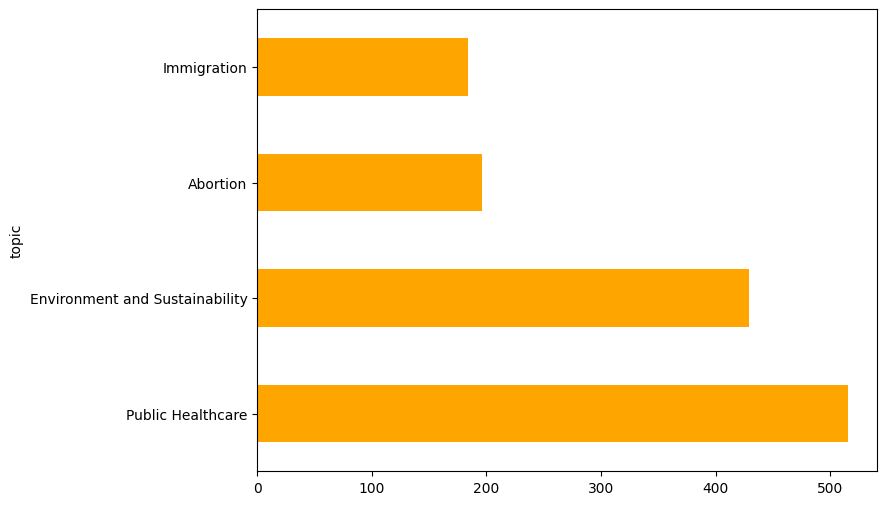

In [563]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
data['topic'].value_counts().plot(kind='barh', color='orange')

In [564]:
# topic and bias - output features

In [565]:
data = data.rename(columns={'Sentiment_Content_nltk': 'nltk Content',
                            'Sentiment_Distil_nltk' : 'nltk Distil',
                            'Sentiment_Falcons_nltk' : 'nltk Falcons',
                            'Sentiment_Bart_nltk' : 'nltk Bart',
                            'Sentiment_Content_cardiffnlp' : 'cardiffnlp Content',
                            'Sentiment_Distil_cardiffnlp' : 'cardiffnlp Distil',
                            'Sentiment_Falcons_cardiffnlp' : 'cardiffnlp Falcons',
                            'Sentiment_Bart_cardiffnlp' : 'cardiffnlp Bart'})

# Specifying columns to round to 1 decimal place
column_names = ['nltk Content', 'nltk Distil', 'nltk Falcons', 'nltk Bart', 
                'cardiffnlp Content', 'cardiffnlp Distil', 'cardiffnlp Falcons', 'cardiffnlp Bart']

data[column_names] = data[column_names].round(1)

data = data[data["Bias"]!= "rated"]

In [566]:
data.head(10)

,Title,News Channel,Bias,topic,News Article Content,Distil_Summary,Falcons_Summary,Bart_Summary,nltk Content,nltk Distil,nltk Falcons,nltk Bart,cardiffnlp Content,cardiffnlp Distil,cardiffnlp Falcons,cardiffnlp Bart
0,Reproductive policy fights renew the focus on IVF,Roll Call,center,Abortion,An Alabama Supreme Court decision legally reco...,Alabama Supreme Court ruled Friday that frozen...,The court on Friday ruled frozen embryos are c...,The Alabama Supreme Court ruled Friday that f...,1.0,0.1,0.0,0.4,0.0,-0.7,0.0,-0.6
3,CVS and Walgreens Will Begin Selling Abortion ...,New York Times (News),left,Abortion,The two largest pharmacy chains in the United ...,CVS and Walgreens will start dispensing the ab...,Officials at CVS and Walgreens said in intervi...,CVS and Walgreens will start dispensing the a...,1.0,0.6,0.0,0.5,0.6,0.5,0.0,0.6
5,"New gun, abortion and labor laws take effect i...",Detroit Free Press,left,Abortion,New Michigan laws approved by Democrats take e...,New Michigan laws approved by Democrats take e...,"Democrats repealed Michigan's ""right-to-work"" ...","Democrats repealed Michigan's ""right-to-work""...",-1.0,0.6,0.4,0.0,0.0,0.0,0.0,0.0
6,Latest 2024 election news: Harris returning to...,Washington Post,left,Abortion,Election 2024\n\nGet the latest news on the 20...,President Biden and Donald Trump both secured ...,Election 2024 Get the latest news on the elect...,President Biden and Donald Trump both secured...,0.8,0.8,0.4,0.8,0.0,0.0,0.0,0.6
7,New York pro-lifers march with ‘joy on steroids’,Catholic News Agency,right,Abortion,The New York Police Department arrested at lea...,The International Gift of Life Walk was held i...,The New York Police Department arrested at lea...,Hundreds of pro-lifers joined the Internation...,0.8,0.7,0.7,0.7,-0.6,0.5,0.7,0.7
9,Trump eyes abortion declaration as polls show ...,MSNBC,left,Abortion,"In recent weeks, Donald Trump has made clear t...",Donald Trump has said he'll make a statement o...,"In recent weeks, Donald Trump has made clear t...",Donald Trump has made clear that he's prepare...,1.0,-0.4,0.8,0.5,0.0,0.0,0.0,0.0
10,Anti-Abortion Advocate Arrested for Sphere Cli...,The Nevada Globe,right,Abortion,"Las Vegas, NV – Maison Des Champs, a 24-year-o...","Maison Des Champs, a 24-year-old self-proclaim...",Maison Des Champs was set to appear in court f...,"Maison Des Champs, a self-proclaimed anti-abo...",1.0,-0.7,0.7,-0.2,0.0,0.0,0.0,0.0
11,Constitutional right to abortion falls short i...,Portland Press Herald,center,Abortion,AUGUSTA — A proposed constitutional right to a...,"In a party-line vote, the Senate voted 20-13 i...","In a party-line vote, the Senate voted 20-13 i...",A proposed constitutional right to abortion f...,1.0,0.4,0.7,0.9,0.0,0.0,0.0,-0.5
13,"Republicans, pro-life advocates urge Dem gover...",Fox News (Online News),right,Abortion,A Republican-led bill that would make coercive...,The bill would make it a felony to coerce a pr...,Republican-led bill would make coercive aborti...,A Republican-led bill that would make coerciv...,-1.0,-0.9,-0.5,-1.0,0.0,0.0,-0.7,-0.5
14,Gov Noem Signs ‘Med Ed’ Bill to Combat Abortio...,Breitbart News,right,Abortion,South Dakota Gov. Kristi Noem (R) signed a fir...,South Dakota Gov. Kristi Noem signed a first-o...,South Dakota Gov. Kristi Noem signed a first-o...,South Dakota Gov. Kristi Noem signed a first-...,1.0,0.8,0.4,-0.6,0.0,0.0,0.0,0.0


In [567]:
le = LabelEncoder()

for col in column_names:
    data[col] = le.fit_transform(data[col])

data['Bias_Label'] = le.fit_transform(data['Bias'])
data['Topic_Label'] = le.fit_transform(data['topic'])


data

,Title,News Channel,Bias,topic,News Article Content,Distil_Summary,Falcons_Summary,Bart_Summary,nltk Content,nltk Distil,nltk Falcons,nltk Bart,cardiffnlp Content,cardiffnlp Distil,cardiffnlp Falcons,cardiffnlp Bart,Bias_Label,Topic_Label
0,Reproductive policy fights renew the focus on IVF,Roll Call,center,Abortion,An Alabama Supreme Court decision legally reco...,Alabama Supreme Court ruled Friday that frozen...,The court on Friday ruled frozen embryos are c...,The Alabama Supreme Court ruled Friday that f...,20,11,10,14,6,3,6,4,0,0
3,CVS and Walgreens Will Begin Selling Abortion ...,New York Times (News),left,Abortion,The two largest pharmacy chains in the United ...,CVS and Walgreens will start dispensing the ab...,Officials at CVS and Walgreens said in intervi...,CVS and Walgreens will start dispensing the a...,20,16,10,15,8,7,6,8,1,0
5,"New gun, abortion and labor laws take effect i...",Detroit Free Press,left,Abortion,New Michigan laws approved by Democrats take e...,New Michigan laws approved by Democrats take e...,"Democrats repealed Michigan's ""right-to-work"" ...","Democrats repealed Michigan's ""right-to-work""...",0,16,14,10,6,6,6,6,1,0
6,Latest 2024 election news: Harris returning to...,Washington Post,left,Abortion,Election 2024\n\nGet the latest news on the 20...,President Biden and Donald Trump both secured ...,Election 2024 Get the latest news on the elect...,President Biden and Donald Trump both secured...,18,18,14,18,6,6,6,8,1,0
7,New York pro-lifers march with ‘joy on steroids’,Catholic News Agency,right,Abortion,The New York Police Department arrested at lea...,The International Gift of Life Walk was held i...,The New York Police Department arrested at lea...,Hundreds of pro-lifers joined the Internation...,18,17,17,17,4,7,9,9,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801,Maria Hunter,Los Angeles Times,left,Immigration,"SVP, Relationship Manager Team Lead Enterprise...","Maria Hunter is SVP, Relationship Manager Team...","SVP, Relationship Manager Team Lead Enterprise...","Maria Hunter, a Nicaraguan native, immigrated...",20,19,18,15,6,9,6,11,1,2
1803,Ecuador President visits NJCU; Archdiocese and...,nj.com,center,Immigration,NJCU hosts Ecuadorian president\n\nNew Jersey ...,NJCU hosts Ecuadorian president Daniel Noboa. ...,NJCU hosts Ecuadorian president New Jersey Cit...,"Daniel Noboa, the newly-elected president of ...",10,10,10,10,6,6,6,6,0,2
1804,El Paso County Commission candidate has histor...,Colorado Springs Gazette,center,Immigration,Close Get email notifications on {{subject}} d...,Close Get email notifications on this story ev...,Close Get email notifications on subject daily...,Get ready for the holidays with your favorite...,11,10,10,19,6,6,6,9,0,2
1806,Prof. Douglas Smith helps combat ongoing Massa...,The Justice,left,Immigration,Massachusetts has reportedly reached its maxim...,Massachusetts is the only Right-to-Shelter sta...,Massachusetts has reportedly reached its maxim...,Massachusetts has reportedly reached its maxi...,20,11,12,11,6,6,6,6,1,2


In [568]:
import nltk


def cleaning_data(text):
    tokens = nltk.tokenize.word_tokenize(text.lower())
    #remove stop words:
    stopword_list = nltk.corpus.stopwords.words('english')
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text


#### Vector Embeddings - Sentence Transformers

In [569]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [570]:
def embeddings(col,data):
    article_texts = data[col].to_list()
    embeddings = []
    for text in article_texts:
        embedding = model.encode(text)
        embeddings.append(embedding)
    return embeddings

In [571]:
from sklearn.model_selection import train_test_split

def inputfeatures_sentence_transformers(data,content,sentiment_nltk,sentiment_cardiffnlp,placeholder):

    # Clean the content
    data["Content_cleaned"] = data[content].apply(lambda x:cleaning_data(x))

    # Create embeddings - Sentence Transformers
    data["Embeddings"] = embeddings("Content_cleaned",data)

    # predicting placeholder - Topic or Bias
    X = data[["Embeddings",sentiment_nltk,sentiment_cardiffnlp]]
    y = data[placeholder]

    # flattened the embeddings
    X_flat = np.array([np.array(embedding).flatten() for embedding in X['Embeddings']])

    # Assume Sentiment_Score is already appropriately scaled or processed
    sentiment_scores_nltk = X[sentiment_nltk].values.reshape(-1, 1)
    sentiment_scores_cardiffnlp = X[sentiment_cardiffnlp].values.reshape(-1, 1)

    # Concatenate the flattened embeddings with the sentiment scores
    X_combined = np.hstack((X_flat, sentiment_scores_nltk,sentiment_scores_cardiffnlp))

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_combined,y)

    return X_train, X_test, y_train, y_test 


#### Logistic Regression

In [572]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


def logistic_regression(X_train, y_train,X_test,y_test):
    logreg = LogisticRegression(n_jobs=5, C=1e5,max_iter=1000)
    logreg.fit(X_train, y_train)
    logreg = logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print(classification_report(y_test, y_pred))


#### XGBoost Classifier

In [573]:
import xgboost as xgb


def xgbclassifier(X_train, y_train,X_test,y_test):
    model = xgb.XGBClassifier(n_jobs=-1,enable_categorical=True)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Evaluate the model performance
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print(classification_report(y_test, predictions))


## Classification Model - Entire News Article Content
- Input Features: News Article Content, and the sentiment scores produced by NLTK as well as cardiffnlp
- Output Features: Topic and Bias 

In [574]:
article_content_data = data[["News Article Content","nltk Content","cardiffnlp Content","Bias_Label","Topic_Label"]]
X_train_topic, X_test_topic, y_train_topic, y_test_topic  = inputfeatures_sentence_transformers(article_content_data,"News Article Content","nltk Content","cardiffnlp Content","Topic_Label")
X_train_bias, X_test_bias, y_train_bias, y_test_bias  = inputfeatures_sentence_transformers(article_content_data,"News Article Content","nltk Content","cardiffnlp Content","Bias_Label")

Predicting Bias

In [575]:
logistic_regression(X_train_bias, y_train_bias,X_test_bias , y_test_bias)
xgbclassifier(X_train_bias, y_train_bias, X_test_bias, y_test_bias)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Accuracy: 55.87%
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       179
           1       0.33      0.36      0.34        73
           2       0.52      0.48      0.50        62
           3       0.00      0.00      0.00         1

    accuracy                           0.56       315
   macro avg       0.38      0.38      0.38       315
weighted avg       0.56      0.56      0.56       315

Accuracy: 65.08%
              precision    recall  f1-score   support

           0       0.70      0.89      0.79       179
           1       0.45      0.32      0.37        73
           2       0.61      0.35      0.45        62
           3       0.00      0.00      0.00         1

    accuracy                           0.65       315
   macro avg       0.44      0.39      0.40       315
weighted avg       0.62      0.65      0.62       315



Predicting Topic

In [576]:
logistic_regression(X_train_topic, y_train_topic, X_test_topic, y_test_topic)
xgbclassifier(X_train_topic, y_train_topic, X_test_topic, y_test_topic)


Accuracy: 77.78%
              precision    recall  f1-score   support

           0       0.79      0.62      0.69        53
           1       0.73      0.88      0.80       100
           2       0.76      0.71      0.73        31
           3       0.83      0.78      0.80       131

    accuracy                           0.78       315
   macro avg       0.78      0.75      0.76       315
weighted avg       0.78      0.78      0.78       315

Accuracy: 79.37%
              precision    recall  f1-score   support

           0       0.84      0.77      0.80        53
           1       0.76      0.87      0.81       100
           2       0.68      0.68      0.68        31
           3       0.83      0.77      0.80       131

    accuracy                           0.79       315
   macro avg       0.78      0.77      0.77       315
weighted avg       0.80      0.79      0.79       315



## Classification Model - distilbart-cnn-12–6 model
- Input Features: News Article Content (summarised by distilbart-cnn-12–6 model), and the sentiment scores produced by NLTK as well as cardiffnlp
- Output Features: Topic and Bias 

In [577]:
distilbart_data = data[["Distil_Summary","nltk Distil","cardiffnlp Distil","Bias_Label","Topic_Label"]]
X_train_bias, X_test_bias, y_train_bias, y_test_bias  = inputfeatures_sentence_transformers(distilbart_data,"Distil_Summary","nltk Distil","cardiffnlp Distil","Bias_Label")
X_train_topic, X_test_topic, y_train_topic, y_test_topic  = inputfeatures_sentence_transformers(distilbart_data,"Distil_Summary","nltk Distil","cardiffnlp Distil","Topic_Label")

Predicting Bias

In [578]:
logistic_regression(X_train_bias, y_train_bias,X_test_bias , y_test_bias)
xgbclassifier(X_train_bias, y_train_bias, X_test_bias, y_test_bias)



Accuracy: 49.84%
              precision    recall  f1-score   support

           0       0.64      0.61      0.62       173
           1       0.30      0.36      0.33        73
           2       0.41      0.38      0.39        69

    accuracy                           0.50       315
   macro avg       0.45      0.45      0.45       315
weighted avg       0.51      0.50      0.50       315

Accuracy: 58.41%
              precision    recall  f1-score   support

           0       0.63      0.85      0.73       173
           1       0.38      0.23      0.29        73
           2       0.53      0.29      0.37        69

    accuracy                           0.58       315
   macro avg       0.51      0.46      0.46       315
weighted avg       0.55      0.58      0.55       315



Predicting Topic

In [579]:
logistic_regression(X_train_topic, y_train_topic, X_test_topic, y_test_topic)
xgbclassifier(X_train_topic, y_train_topic, X_test_topic, y_test_topic)

Accuracy: 71.11%
              precision    recall  f1-score   support

           0       0.74      0.77      0.75        52
           1       0.75      0.70      0.72       112
           2       0.74      0.60      0.67        43
           3       0.66      0.74      0.70       108

    accuracy                           0.71       315
   macro avg       0.72      0.70      0.71       315
weighted avg       0.72      0.71      0.71       315

Accuracy: 71.75%
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        52
           1       0.69      0.78      0.73       112
           2       0.92      0.51      0.66        43
           3       0.66      0.70      0.68       108

    accuracy                           0.72       315
   macro avg       0.78      0.70      0.72       315
weighted avg       0.73      0.72      0.72       315



## Classification Model - facebook/bart-large-cnn
- Input Features: News Article Content (summarised by facebook/bart-large-cnn), and the sentiment scores produced by NLTK as well as cardiffnlp
- Output Features: Topic and Bias 

In [580]:
bart_large_data = data[["Bart_Summary","nltk Bart","cardiffnlp Bart","Bias_Label","Topic_Label"]]
X_train_bias, X_test_bias, y_train_bias, y_test_bias  = inputfeatures_sentence_transformers(bart_large_data,"Bart_Summary","nltk Bart","cardiffnlp Bart","Bias_Label")
X_train_topic, X_test_topic, y_train_topic, y_test_topic  = inputfeatures_sentence_transformers(bart_large_data,"Bart_Summary","nltk Bart","cardiffnlp Bart","Topic_Label")

In [581]:
logistic_regression(X_train_bias, y_train_bias,X_test_bias , y_test_bias)
xgbclassifier(X_train_bias, y_train_bias, X_test_bias, y_test_bias)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Accuracy: 52.70%
              precision    recall  f1-score   support

           0       0.73      0.60      0.66       196
           1       0.33      0.41      0.36        69
           2       0.31      0.42      0.36        50

    accuracy                           0.53       315
   macro avg       0.45      0.47      0.46       315
weighted avg       0.57      0.53      0.54       315

Accuracy: 66.03%
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       196
           1       0.48      0.36      0.41        69
           2       0.50      0.32      0.39        50

    accuracy                           0.66       315
   macro avg       0.57      0.51      0.53       315
weighted avg       0.63      0.66      0.64       315



In [582]:
logistic_regression(X_train_topic, y_train_topic, X_test_topic, y_test_topic)
xgbclassifier(X_train_topic, y_train_topic, X_test_topic, y_test_topic)

Accuracy: 71.11%
              precision    recall  f1-score   support

           0       0.81      0.67      0.73        51
           1       0.74      0.63      0.68       106
           2       0.70      0.76      0.73        50
           3       0.66      0.79      0.72       108

    accuracy                           0.71       315
   macro avg       0.73      0.71      0.72       315
weighted avg       0.72      0.71      0.71       315

Accuracy: 73.97%
              precision    recall  f1-score   support

           0       0.87      0.65      0.74        51
           1       0.70      0.74      0.72       106
           2       0.87      0.68      0.76        50
           3       0.69      0.81      0.75       108

    accuracy                           0.74       315
   macro avg       0.78      0.72      0.74       315
weighted avg       0.75      0.74      0.74       315



## Classification Model - Falconsai/text_summarization
- Input Features: News Article Content (summarised by Falconsai/text_summarization), and the sentiment scores produced by NLTK as well as cardiffnlp
- Output Features: Topic and Bias 

In [583]:
falcons_data = data[["Falcons_Summary","nltk Falcons","cardiffnlp Falcons","Bias_Label","Topic_Label"]]
X_train_bias, X_test_bias, y_train_bias, y_test_bias  = inputfeatures_sentence_transformers(falcons_data,"Falcons_Summary","nltk Falcons","cardiffnlp Falcons","Bias_Label")
X_train_topic, X_test_topic, y_train_topic, y_test_topic  = inputfeatures_sentence_transformers(falcons_data,"Falcons_Summary","nltk Falcons","cardiffnlp Falcons","Topic_Label")

In [584]:
logistic_regression(X_train_bias, y_train_bias,X_test_bias , y_test_bias)
xgbclassifier(X_train_bias, y_train_bias, X_test_bias, y_test_bias)

Accuracy: 47.30%
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       177
           1       0.35      0.37      0.36        87
           2       0.25      0.35      0.29        49
           3       0.00      0.00      0.00         2

    accuracy                           0.47       315
   macro avg       0.31      0.32      0.31       315
weighted avg       0.50      0.47      0.48       315

Accuracy: 61.27%
              precision    recall  f1-score   support

           0       0.66      0.89      0.75       177
           1       0.49      0.22      0.30        87
           2       0.46      0.35      0.40        49
           3       0.00      0.00      0.00         2

    accuracy                           0.61       315
   macro avg       0.40      0.36      0.36       315
weighted avg       0.58      0.61      0.57       315



In [585]:
logistic_regression(X_train_topic, y_train_topic, X_test_topic, y_test_topic)
xgbclassifier(X_train_topic, y_train_topic, X_test_topic, y_test_topic)

Accuracy: 69.84%
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        47
           1       0.71      0.60      0.65       101
           2       0.69      0.74      0.72        46
           3       0.69      0.72      0.70       121

    accuracy                           0.70       315
   macro avg       0.70      0.72      0.71       315
weighted avg       0.70      0.70      0.70       315

Accuracy: 75.87%
              precision    recall  f1-score   support

           0       0.86      0.79      0.82        47
           1       0.75      0.75      0.75       101
           2       0.78      0.61      0.68        46
           3       0.73      0.81      0.77       121

    accuracy                           0.76       315
   macro avg       0.78      0.74      0.76       315
weighted avg       0.76      0.76      0.76       315

